# Рекомендательная система на базе датасета **movielens**

Один из наиболее известных датасетов в мире рекомендательных систем - Movielens 25M, содержащий рейтинги к фильмам, оставленные различными пользователями на одноименном сайте https://movielens.org/.

Мы будем использовать мини-версию датасета, содержащую 100 тысяч записей рейтингов фильмов.

## Загрузка данных

Для создания алгоритмов рекомендательной системы, будем использовать библиотеку **surprise**.

Установим её, если она ещё не установлена на компьютер.

In [1]:
!pip install scikit-surprise

     |████████████████████████████████| 11.8 MB 3.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619422 sha256=da13d404a9cbaddb17d02e2df7e17f913032cc0cfef24a49d48d7c9f2ee69a9d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
from surprise import Dataset

Загружаем датасет из **surprise**

In [3]:
data = Dataset.load_builtin("ml-100k", prompt=False)

Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


**Замечание для любителей настоящих данных**

Вы можете попробовать загрузить полную верисю датасета (`'ml-1m'`) и попробовать сделать задание на нём.

Но вычисления будут занимать большее количество времени (и требовать некоторого железа).

За использование расширенного датасета не будет бонусов в оценке (да и результатах по большей части тоже) - только ваш энтузиазм.

## Визуализация данных

Для удобной работы с данными загрузим библиотеку **pandas**

In [4]:
import pandas as pd
import numpy as np

Преобразуем данные к формату **pandas DataFrame**, для удобной работы с ними:

In [5]:
df = pd.DataFrame(data.raw_ratings, columns=["userId", "movieId", "rating", "timestamp"])

In [109]:
df.head()

,userId,movieId,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


*  Колонка **userId** - идентификаторы пользователей сайта movielens;
*  Колонка **movieId** - идентификаторы фильмов;
*  Колонка **rating** - оценки фильмов пользователями по шкале от 1 до 5;
*  Колонка **timestamp** - это время оценки фильма пользователем. Данный формат представления времени показывает, сколько секунд прошло с 1 января 1970 года.

Мы можем посмотреть, сколько уникальных значений находится в каждой из колонок.

In [7]:
df.apply("nunique")

userId         943
movieId       1682
rating           5
timestamp    49282
dtype: int64

Для корректной работы с графиками в python требуется загрузить специальную библиотеку
**matplotlib**, программную библиотеку на языке python для визуализации данных двумерной и трехмерной графикой.

Посмотрим наглядно, как часто в датасете встречаются разные оценки:

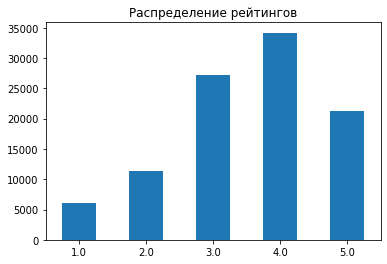

In [8]:
df["rating"].value_counts().sort_index().plot.bar(title="Распределение рейтингов", rot=0);

## Разбиение выборки на обучающую и тестовую

Библиотека **surprise** высокоуровневая, и позволяет нам разбить данные на обучающую и тестовую выборки всего одной функцией **train_test_split()**

In [9]:
from surprise.model_selection import train_test_split

Функция **train_test_split()** принимает на вход два параметра:
*  **data** - данные
*  **test_size** - доля тестовой выборки. Укажем 0,25, чтобы тестовая выборка составляла 25% от всей выборки.

In [10]:
trainset, testset = train_test_split(data, test_size=0.25)

# Задание 1

Проведите исследование данных (exploratory data analysis, EDA).

Выясните:

1. Сколько оценок в среднем поставил один человек (и какова выборочная дисперсия этой величины)
2. Сколько оценок в среднем имеет один фильм (+дисперсия)

Также для каждой из этих величин постройте гистограму (или violin plot) распределения чтобы увидеть картину целиком. Возможно вам понадобится использовать логарифмический масштаб осей (эту настройку можно передать в matplotlib).

In [11]:
# Ваш код тут
def count_pers(tb):
  res = {
      'Estimations_mean': tb['rating'].mean(),
      'Estimations_std': np.array(tb['rating']).std()
  }
  return pd.Series(res)

df_estimators = df.groupby('userId').apply(count_pers)
critic_values = np.array(df_estimators.Estimations_mean)
print("Сколько оценок в среднем поставил один человек", critic_values.mean(), "выборочная дисперсия этой величины",critic_values.std())
def count_films(tb):
  res = {
      'Estimations_mean': tb['rating'].mean(),
      'Estimations_std': np.array(tb['rating']).std()
  }
  return pd.Series(res)

df_estimators = df.groupby('movieId').apply(count_films)
movie_values = np.array(df_estimators.Estimations_mean)
print("Сколько оценок в среднем имеет один фильм", movie_values.mean(), "выборочная дисперсия этой величины",movie_values.std())

Сколько оценок в среднем поставил один человек 3.5881911071848007 выборочная дисперсия этой величины 0.44499735963709314
Сколько оценок в среднем имеет один фильм 3.076044508325179 выборочная дисперсия этой величины 0.7814291365022871


In [33]:
import matplotlib.pyplot as plt


def plot_pdf(values: np.ndarray, title: str):
    """Plots `values` distribution density"""
    plt.figure(figsize=(10, 5))
    plt.violinplot(values.flatten(), vert=False, showmedians=True)
    plt.xlabel("Similarity")
    plt.grid()
    plt.title(title)
    plt.show()

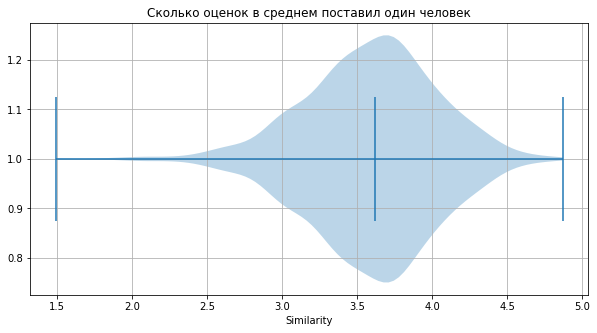

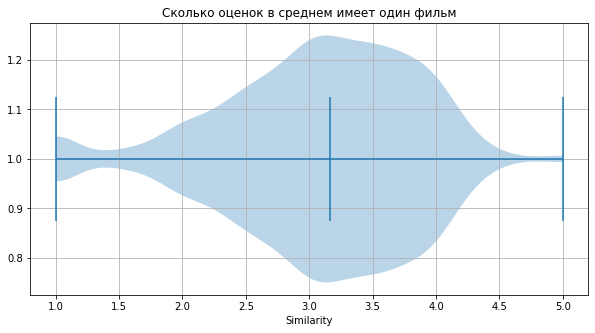

In [37]:
plot_pdf(critic_values, "Сколько оценок в среднем поставил один человек")
plot_pdf(movie_values, "Сколько оценок в среднем имеет один фильм")


## Построение простой модели

In [12]:
from surprise import SVD, KNNBasic, accuracy

Инициализируем алгоритм. Алгоритм SVD - один из самых распространенных методов матричной факторизации (представления матрицы в виде произведения нескольких матриц). Такое представление позволяет анализировать похожие матрицы и раскладывать их на так называемые "компоненты". А так же, восстанавливая матрицы их этих компонент - заполнять недостающие значения (в нашем случае - оценки). Почитать можно здесь: http://www.albertauyeung.com/post/python-matrix-factorization/

In [13]:
algo = SVD()

Тренируем на тренировочной выборке алгоритм.

In [14]:
algo.fit(trainset)

Делаем предсказание на тестовой выборке.

In [51]:
predictions = algo.test(testset)

In [52]:
testset

[('98', '745', 3.0),
 ('496', '10', 5.0),
 ('301', '123', 4.0),
 ('932', '135', 5.0),
 ('18', '729', 3.0),
 ('484', '313', 5.0),
 ('280', '140', 4.0),
 ('326', '196', 4.0),
 ('221', '204', 4.0),
 ('569', '924', 3.0),
 ('299', '154', 4.0),
 ('916', '451', 3.0),
 ('210', '243', 2.0),
 ('83', '631', 2.0),
 ('438', '252', 4.0),
 ('717', '250', 1.0),
 ('489', '310', 4.0),
 ('936', '678', 3.0),
 ('342', '514', 5.0),
 ('474', '584', 5.0),
 ('151', '705', 5.0),
 ('323', '333', 4.0),
 ('13', '423', 5.0),
 ('934', '403', 4.0),
 ('293', '637', 3.0),
 ('537', '349', 1.0),
 ('902', '328', 3.0),
 ('858', '181', 2.0),
 ('305', '179', 1.0),
 ('514', '735', 4.0),
 ('82', '597', 3.0),
 ('63', '1007', 5.0),
 ('524', '402', 2.0),
 ('535', '171', 3.0),
 ('318', '809', 4.0),
 ('397', '181', 4.0),
 ('416', '803', 3.0),
 ('863', '352', 1.0),
 ('239', '497', 4.0),
 ('863', '315', 5.0),
 ('938', '259', 2.0),
 ('738', '42', 2.0),
 ('169', '300', 5.0),
 ('804', '554', 2.0),
 ('474', '1134', 3.0),
 ('457', '294', 

In [17]:
accuracy.rmse(predictions);

RMSE: 0.9446


## Кросс-валидация

Обучая любой алгоритм машинного обучения мы, фактически, "подгоняем" модель под данные, которые ей подаём. Но, если подгонять слишком сильно, то модель переобучится. То есть модель начнёт запоминать ответы вместо того, чтобы выявлять закономерности. 

На графиках ниже точки тренировочной выборки:
*  слева - недообученная модель (большая ошибка на тренировочной выборке; большая ошибка на тестовой выборке)
*  посередине - хорошо обученная модель (маленькая ошибка на тренировочной выборке; маленькая ошибка на тестовой выборке)
*  справа - переобученная модель (очень маленькая или нулевая ошибка на тренировочной выборке; большая ошибка на тестовой выборке)

<p align="center">
  <img src="https://drive.google.com/uc?id=1Eg4Xg4o-lhzrgqNNmNQCtB1RxNJmnmWx" alt="Drawing" style="width: 700px;" width="700"/>
</p>

Таким образом, обучая модель, мы всегда уменьшаем ошибку на тренировочной выборке. Вместе с ошибкой на тренировочной выборке, падает и ошибка на тестовой. Но после какого-то момента, модель начинает переобучатся, и ошибка на тестовой выборке начинает расти, в то время, как ошибка на тренировочной выборке продолжает падать. 

<p align="center">
  <img src="https://drive.google.com/uc?id=1mvU_jJIe07tAoX82qODcpmTBctx0ReuT" alt="Drawing" style="width: 700px;" width="700"/>
</p>

Может получится ситуация, когда мы видим маленькую ошибку нашей модели, и думаем, что она хорошая, но на самом деле она просто переобучилась, и на новых данных покажет плохой результат.

Чтобы избежать такой ситуации можно использовать отложенную выборку. То есть мы разбиваем наши данные на **тренировочную** выборку, **тестовую** выборку и **отложенную** выборку. Соответственно, обучаем модель на тренировочной, в ходе обучения проверяем результат на тестовой выборке, а в конце обучения, чтобы оценить качество модели, ошибку считаем на отложенной выборке.

При таком подходе в обучении модели участвует только тренировочная выборка. Тестовую и отложенную мы используем только для проверки. Если у нас мало данных, отложенная выборка - непозволительная роскошь. 

Другой популярный подход это **кросс-валидация** или скользящий контроль. Суть метода заключается в том, что мы дераем не одно разбиение датесета, а несколько разбиений таким образом, чтобы все данные использовались и в обучении и для проверки. Такие разбиения называются **фолдами**. 

Преимущества такого подхожа в том, что мы используем все данные для обучения. Также это позволяет оценить устойчивость модели. Если ошибки полученные на разных фолдах сильно отличаются, что модель неустойчива.
Недостаток метода в том, что нам нужно обучать не одну модель, а несколько (столько, сколько мы выбрали фолдов).

На практике часто выбирают 5 фолдов.

<p align="center">
  <img src="https://drive.google.com/uc?id=1C9eHgCi30X08XaSScmjqIOT3ayBtBiFw" alt="Drawing" style="width: 500px;" width="300"/>
</p>

In [19]:
from surprise.model_selection import cross_validate

Используем функцию **cross_validate** из модуля **model_selection** библиотеки **surprise**.

Функция принимает на вход:
*  algo - алгоритм, который будем обучать.
*  data - исходные данные. Обратите внимание, что данные передаём не разбитые на выборки.
*  measures - метрики ошибок по которым мы хотим сравнивать модели. Мы передаём среднеквадратичную ошибку и среднюю ошибку.
* cv - количество фолдов.
*  verbose - параметр указывающий хотим ли мы увидеть подробный результат выполнения функции.

In [20]:
algo = SVD()
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9332  0.9365  0.9284  0.9398  0.9431  0.9362  0.0051  
MAE (testset)     0.7387  0.7361  0.7328  0.7398  0.7435  0.7382  0.0036  
Fit time          4.82    4.78    4.82    4.78    4.80    4.80    0.02    
Test time         0.17    0.29    0.17    0.26    0.28    0.23    0.05    


{'fit_time': (4.818059921264648,
  4.779477119445801,
  4.8242902755737305,
  4.780812740325928,
  4.802828073501587),
 'test_mae': array([0.7387244 , 0.73608483, 0.73278861, 0.73979112, 0.74350961]),
 'test_rmse': array([0.93316063, 0.93646481, 0.92840548, 0.93983396, 0.94312725]),
 'test_time': (0.17313027381896973,
  0.2908289432525635,
  0.17102503776550293,
  0.2593667507171631,
  0.27565526962280273)}

В результате получаем значения ошибок на каждом из фолдов, а также их среднее и стандартное отклонение (СО). Маленькое СО, как в нашем случае, говорит об устойчивости модели.

Дополнительно мы видим время тренировки и время предсказания модели на каждом из фолдов.

## Поиск по сетке (Grid search)

Теперь, когда у нас есть надёжный способ оценивать качество модели, мы можем перейти к подбору гиперпараметров модели, т.е. параметров, которые нужно указывать вручную, потому что нельзя обучить во время тренировки модели.

Метод поиска по сетке очень прост. Мы передаём варианты каждого из параметров, который мы хотим перебрать, а функция перебирает все возможные варианты переданных параметров. Например, на картинке ниже перебираются параметры "регуляризация" и "скорость обучения".

<p align="center">
  <img src="https://drive.google.com/uc?id=1xs9z_Zo1A2QinErKYEB-bp6eGnLWodbO" alt="Drawing" style="width: 700px;" width="700"/>
</p>

# Задание 2

## Часть 1

Оптимизируйте следующие параметры алгоритма SVD:

* n_epochs - количество эпох обучения
* lr_all - скорость обучения
* reg_all - регуляризация

Более детальное описание алгоритма смотри в [документации](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

P.S. не нужно делать слишком большую сетку перебора - если время расчёта отнимает больше 10 мин, то это уже очень много (для базового датасета).

In [21]:
from surprise.model_selection import GridSearchCV

Для перебора по сетке используем функцию **GridSearchCV**. 
На вход подаём:
* алгоритм.
* параметры, которые хотим перебрать.
* метрики ошибок.
* количество фолдов для кросс-валидации.

Обратите внимание, что функция выполняет кросс-валидация автоматически.

In [22]:
# Ваш код тут
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
algo = SVD
gs = GridSearchCV(algo, param_grid, measures=["rmse", "mae"], cv=5, refit=True)

gs.fit(data)
best_params = gs.best_params["rmse"]

print("RMSE: \t", gs.best_score["rmse"])
print("MAE: \t", gs.best_score["mae"])
print("params: \t", gs.best_params["rmse"])

RMSE: 	 0.961563207541176
MAE: 	 0.7705427112666001
params: 	 {'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [33]:
algo = SVD(n_epochs = best_params['n_epochs'], lr_all = best_params['lr_all'], reg_all = best_params['reg_all'])
algo.fit(trainset)
algo.predict(100, 500, verbose=True)

user: 100        item: 500        r_ui = None   est = 3.53   {'was_impossible': False}


Prediction(uid=100, iid=500, r_ui=None, est=3.5304, details={'was_impossible': False})

In [31]:
user = 100500
item = 100500
gs.predict(user, item)

Prediction(uid=100500, iid=100500, r_ui=None, est=3.52986, details={'was_impossible': False})

## Часть 2

Выберите другую модель из scikit surprise для предсказания рекомендаций (полный список смотри в [документации](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html)).\
И настройте её параметры с помощью поиска по сетке.

Сравните результаты с предыдущей моделью.

In [34]:
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
algo = KNNBasic
gs = GridSearchCV(algo, param_grid, measures=["rmse", "mae"], cv=5, refit=True)

gs.fit(data)

print("RMSE: \t", gs.best_score["rmse"])
print("MAE: \t", gs.best_score["mae"])
print("params: \t", gs.best_params["rmse"])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [35]:
algo = SVD(n_epochs = best_params['n_epochs'], lr_all = best_params['lr_all'], reg_all = best_params['reg_all'])
algo.fit(trainset)
algo.predict(100, 500, verbose=True)

user: 100        item: 500        r_ui = None   est = 3.53   {'was_impossible': False}


Prediction(uid=100, iid=500, r_ui=None, est=3.5304, details={'was_impossible': False})

In [89]:
from surprise.prediction_algorithms.knns import KNNBasic

sim_options = {'name': 'cosine',
               'user_based': False, 
               'measures': ["rmse", "mae"],
               }
algo_knn_basic = KNNBasic(sim_options=sim_options)
predictions = algo_knn_basic.fit(trainset).test(testset)
print(accuracy.mae(predictions), accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
MAE:  0.8142
RMSE: 1.0291
0.8142020672279752 1.0291372592253227


In [90]:
# Ваш код тут
pd.DataFrame(predictions, columns=['user_id', 'item_id', 'eval', 'predict_eval', 'details'])

,user_id,item_id,eval,predict_eval,details
0,279,1497,2.0,3.175000,"{'actual_k': 40, 'was_impossible': False}"
1,295,570,3.0,4.373722,"{'actual_k': 40, 'was_impossible': False}"
2,42,1044,4.0,3.571158,"{'actual_k': 40, 'was_impossible': False}"
3,537,88,2.0,2.749962,"{'actual_k': 40, 'was_impossible': False}"
4,222,450,3.0,2.197249,"{'actual_k': 40, 'was_impossible': False}"
...,...,...,...,...,...
24995,466,127,3.0,3.824878,"{'actual_k': 40, 'was_impossible': False}"
24996,13,793,5.0,3.200000,"{'actual_k': 40, 'was_impossible': False}"
24997,636,25,5.0,4.339302,"{'actual_k': 12, 'was_impossible': False}"
24998,195,469,3.0,3.492844,"{'actual_k': 40, 'was_impossible': False}"


# Задание 3

С помощью натренированной модели (любой из предыдущих) постройте по 3 рекомендации для каждого клиента из тестовой выборки.

Проанализируйте полученные результаты: сколько раз был порекомендован каждый фильм? Каково распределение этих частот? (постройте гистограму)

In [78]:
three_predict = []
for user, item_1, val_1 in testset:
  favor_film = []
  for user, item, val in testset:
    tmp = list(gs.predict(user, item))
    answer = (val, tmp[1])
    # print(answer)
    favor_film.append(answer)
  print(sorted(favor_film)[:3])
  break
    # three_predict.append()




[(1.0, '1'), (1.0, '1'), (1.0, '10')]


In [ ]:
# Ваш код тут
predictions = []
for user, item, val in testset:
  tmp = list(gs.predict(user, item))
  tmp[2] = val
  predictions.append(tmp)


  
result = pd.DataFrame(predictions, columns=['user_id', 'item_id', 'eval', 'predict_eval', 'details'])
result.drop(columns = {'details'}, inplace = True)
result['erro'] = abs(result['eval'] - result['predict_eval'])






In [146]:
result

,user_id,item_id,eval,predict_eval,erro
0,98,745,3.0,3.783858,0.783858
1,496,10,5.0,4.040904,0.959096
2,301,123,4.0,3.336214,0.663786
3,932,135,5.0,4.524362,0.475638
4,18,729,3.0,3.590114,0.590114
...,...,...,...,...,...
24995,883,873,3.0,2.910168,0.089832
24996,321,56,4.0,3.940097,0.059903
24997,497,177,4.0,3.873073,0.126927
24998,699,880,3.0,3.386576,0.386576


In [170]:
# 1 approach
from tqdm import tqdm
recomend_dict = {}
for user in tqdm(list(result['user_id'])):
  filt = result['user_id'] == user
  tmp = result[filt].copy()
  tmp.sort_values(by='predict_eval', inplace=True)
  recomend_dict[user] = []
  for i in range(3):
    if i < len(tmp['item_id']):
      recomend_dict[user].append(list(tmp['item_id'])[i])
    else:
      recomend_dict[user].append(None)
  

pd.DataFrame(recomend_dict).T


100%|██████████| 25000/25000 [01:24<00:00, 295.66it/s]


,0,1,2
98,988,168,502
496,743,1139,1157
301,1230,1052,1013
932,1139,541,560
18,476,94,716
...,...,...,...
888,644,None,None
651,690,327,None
228,327,650,204
706,25,258,181


In [167]:
df_recomendation = pd.DataFrame(recomend_dict).T.rename(columns={0:'1_film',1:'2_film',2:'3_film'})
films= []
for col in df_recomendations.columns:
  films.extend(df_recomendations[col])

# top 10 films
pd.Series(films).value_counts()[:10]

112                   944
110                   944
34                    944
2.430840551164029     943
2.4128730805700864    943
2.2523091512810964    943
801                     1
91                      1
427                     1
35                      1
dtype: int64

In [168]:
# 2 approach
def first_3(table):
  table.sort_values(by=['predict_eval'], inplace=True)
  res = {}
  columns= []
  for i in range(len(table)):
    if i == 3:
      break
    res[f'item_id_{i}'] = list(table['item_id'])[i]
    res[f'predict_eval_{i}'] = list(table['predict_eval'])[i]
    columns.append(f'predict_eval_{i}')
    columns.append(f'item_id_{i}')
  return pd.Series(res, index=columns)
  
df_recomendations = result.groupby(['user_id']).apply(first_3).reset_index()


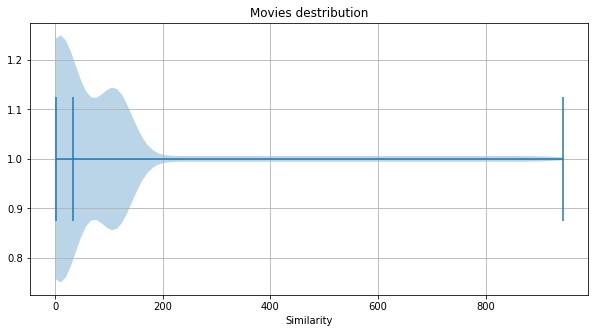

In [173]:
import matplotlib.pyplot as plt


def plot_pdf(values: np.ndarray, title: str):
    """Plots `values` distribution density"""
    plt.figure(figsize=(10, 5))
    plt.violinplot(values.flatten(), vert=False, showmedians=True)
    plt.xlabel("Similarity")
    plt.grid()
    plt.title(title)
    plt.show()

plot_pdf(np.array(films).astype(np.float), 'Movies destribution')

# Задание 4 * (Дополнительное)

В оригинальных данных есть поле `timestamp` (см. момент загрузки данных).

Используя оптимальный вариант модели (и её гиперпараметров), найденный выше, проведите кросс-валидацию в стиле временного ряда (см. [документацию sklearn](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split)). Достаточно использовать 5 частей. Иными словами, нужно раделить выборку на равные части, каждая из которых будет соответствовать последовательным временным промежуткам.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png)

Нашли ли вы отличия с предыдущей валидацией?

In [ ]:
# Ваш код тут